# Reporte de práctica 7: Regresión múltiple con statsmodels

En esta práctica es parecida a la anterior, solo que ahora los modelos lineales tendrán más de un factor.

## Objetivo 
- Incluir por lo menos un modelo de regresión múltiple 
- Intentar usar sus resultados como un clasificador de alguna variable de interés para el proyecto.

### Cargar datos de csv

Primero importamos el archivo que está en GitHub que tiene información limpia de prácticas pasadas.

In [1]:
import statsmodels.api as sm
from numpy import isnan
import pandas as pd
cine = pd.read_excel('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/2018.xlsx', index_col=None, header=0, sheet_name=0)
cine = cine[['Categoria','Edad','Pais', 'Titulo','Genero', 'Duracion', 'Marca','Referencia','Dias','Marcas','Personas','Sinopsis']]

cine = cine.dropna()

print(len(cine))

266


Se quiere probar si el tamaño de la sinopsis de los filmes puede expresarse en la relación entre el género, categoría y país del filme y marca del smartphone utilizado para grabar el filme. Se categoriza utilizando la librería pandas.Categorical().

In [2]:
cine['sin'] = cine["Sinopsis"].str.len()

gen = pd.Categorical(cine.Genero)
cine['gen'] = gen.codes

cat = pd.Categorical(cine.Categoria)
cine['cat'] = cat.codes

pai = pd.Categorical(cine.Pais)
cine['pai'] = pai.codes

cel= pd.Categorical(cine.Marca)
cine['cel'] = cel.codes

## Mínimos cuadrados ordinarios

Los mínimos cuadrados ordinarios sirven para encontrar los parámetros poblacionales en un modelo de regresión lineal. Este método minimiza la suma de las distancias verticales entre las respuestas observadas en la muestra y las respuestas del modelo. El parámetro resultante puede expresarse a través de una fórmula sencilla, especialmente en el caso de un único factor. 

Para hacer la regresión se confirma que la cantidad de datos que se tienen sea mayor a ocho.

In [3]:
n = len(cine)
if n >= 8: 
    y = cine["sin"]
    x = cine[["cat", "gen", "pai","cel"]]
    #x = sm.add_constant(x) 
    m = sm.OLS(y, x).fit() 
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                    sin   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     79.82
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           3.34e-44
Time:                        17:06:52   Log-Likelihood:                -1975.1
No. Observations:                 266   AIC:                             3958.
Df Residuals:                     262   BIC:                             3972.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat          -13.5855     14.709     -0.924      0.3

Se verifica si los campos se encuentran correlacionados entre ellos. Por que afectaría si en el modelo trabajamos con columnas que estén fuertemente correlacionados.

          sin       gen       cat       pai       cel
sin  1.000000  0.114942 -0.070866 -0.078453 -0.052292
gen  0.114942  1.000000  0.074064  0.011594  0.066744
cat -0.070866  0.074064  1.000000  0.110990 -0.073326
pai -0.078453  0.011594  0.110990  1.000000  0.022980
cel -0.052292  0.066744 -0.073326  0.022980  1.000000


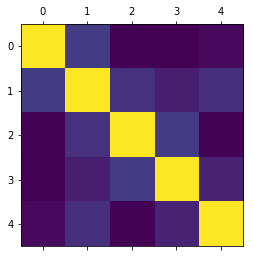

In [4]:
import matplotlib.pyplot as plt
cine = pd.DataFrame(cine, columns = ["sin","gen", "cat", "pai","cel"])
f = plt.figure(figsize = (9, 9))  
print(cine.corr())
sf = f.add_subplot(211)
tmp = sf.matshow(cine.corr())

Se puede ver que ningún parámetro se encuentra fuertemente correlacionado. Esto indica que todos los parámetros son independientes.

Se realiza una grafica de dispersión para determinar que variables nos conviene estudiar.

266


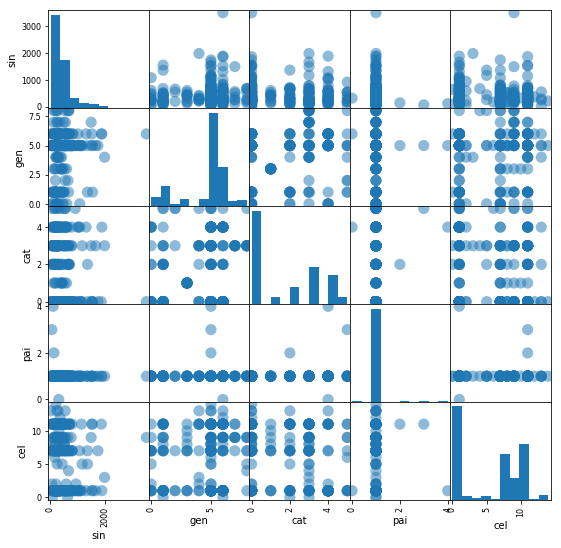

In [5]:
print(len(cine))
cine = pd.DataFrame(cine, columns = ["sin","gen", "cat", "pai","cel"])
tmp = pd.plotting.scatter_matrix(cine, figsize = (9, 9), s =500) 

En este caso, los datos se encuentran dispersos. Se puede observar que no están correlacionados. En los histogramas de la diagonal principal se observa que la distribución de los datos no es normalmente distribuida.

## Usar los resultados como clasificador

A pesar de que no se obtuvieron los resultados deseados, se intenta predecir el tamaño de la sinopsis en función del género, categoría y país del filme y la marca del smartphone con el cual se grabó el filme. Este tamaño no deberá ser mayor a 140 caracteres, como limite de Twitter.

In [6]:
cine = pd.DataFrame(cine, columns = ["sin","gen", "cat", "pai","cel"])
cine = cine.dropna()
y = cine["sin"]
x = cine[["gen", "cat", "pai","cel"]]
m = sm.OLS(y, x).fit() 
comp = pd.DataFrame(cine, columns = ["sin"])
comp['pron'] = m.predict(x) 
comp['error'] = comp.sin - comp.pron
comp['absE'] = pd.DataFrame.abs(comp['error'])
orden = comp.sort_values(by = ['absE'])
mejores = orden.head(10)
mejores.insert(0, 'tipo', 'mejores')
peores = orden.tail(10)
peores.insert(0, 'tipo', 'peores')
pd.concat([mejores, peores])
n = len(comp)
for e in [1, 5, 10]:
    k = sum(comp.absE < e)
    print(k, "de", n , "= {:.2f}% estuvieron dentro de".format(100 * k / n), e, "caracteres permitidos en Twitter")

1 de 266 = 0.38% estuvieron dentro de 1 caracteres permitidos en Twitter
2 de 266 = 0.75% estuvieron dentro de 5 caracteres permitidos en Twitter
5 de 266 = 1.88% estuvieron dentro de 10 caracteres permitidos en Twitter


Se vera qué tanto cambia si no usamos el estimado del la marca del smartphone. Para esto se considerarán las siguientes variables.


    fp = falsos positivos: según el modelo pasan, pero en realidad no pasan.
    fn = falsos negativos: según el modelo reprueban, pero en realidad pasan.
    tp = verdaderos positivos: pasan en la realidad y también según el modelo.
    tn = verdaderos negativos: reprueban en la realidad y también según el modelo.

Teniendo tt = tp + tn + fp + fn podemos calcular

    La sensibilidad: tp / (tp + fn) que mide qué tan bien se modela los que aprueban.
    La especificidad: tn / (tn + fp) que mide qué tan bien se modela los que reprueban.
    La precisión: (tp + tn) / tt que mide el desempeño total de La asignación correcta de la clasificación que concluimos de este modelo lineal de regresión múltiple.

In [7]:
cine = pd.DataFrame(cine, columns = ["sin","gen", "cat", "pai","cel"])
cine = cine.dropna()
y = cine["sin"]
x = cine[["gen", "cat", "pai"]]
m = sm.OLS(y, x).fit() 
comp = pd.DataFrame(cine, columns = ["sin"])
comp['pron'] = m.predict(x) 
comp['error'] = comp.sin - comp.pron
comp['absE'] = pd.DataFrame.abs(comp['error'])
orden = comp.sort_values(by = ['absE'])
mejores = orden.head(10)
mejores.insert(0, 'tipo', 'mejores')
peores = orden.tail(10)
peores.insert(0, 'tipo', 'peores')
pd.concat([mejores, peores])
n = len(comp)
for e in [1, 5, 10]:
    k = sum(comp.absE < e)
    print(k, "de", n , "= {:.2f}% estuvieron dentro de".format(100 * k / n), e, \
          "caracteres permitidos en Twitter")
    
    
    
fp = sum((comp.sin < 140) & (comp.pron >= 140))
fn = sum((comp.sin >= 140) & (comp.pron < 140))
tp = sum((comp.sin >= 140) & (comp.pron >= 140))
tn = sum((comp.sin < 140) & (comp.pron < 140))
print('Clasificación')
print(fp, fn, tp, tn)
tt = tp + tn + fp + fn
print('sensibilidad', tp / (tp + fn))
print('especificidad', tn / (tn + fp))
print('precisión', (tp + tn) / tt)

0 de 266 = 0.00% estuvieron dentro de 1 caracteres permitidos en Twitter
2 de 266 = 0.75% estuvieron dentro de 5 caracteres permitidos en Twitter
6 de 266 = 2.26% estuvieron dentro de 10 caracteres permitidos en Twitter
Clasificación
23 0 243 0
sensibilidad 1.0
especificidad 0.0
precisión 0.9135338345864662


A pesar de que esta versión tiene mejores resultados, parece que este modelo es incapaz de predecir o clasificar, falsos negativos y verdaderos negativos ya que la función con la que predice no es muy buena.

## Conclusión

Se trabajó con parámetros que eran cadenas de caracteres y se utilizó la función Categorical para convertirlos a números y poder hacer la regresión tomando en cuenta estos parámetros no numéricos. Al hacer la regresión de mínimos cuadrados ordinarios se obtuvo un valor de R2 de 0.549. Se intentó clasificar los filmes con sus sinopsis. Donde se filtraban los elementos que fueran menores o iguales a 140 caracteres, para poder determinar si las sinopsis podían ser publicadas en Twitter. Con lo cual solo se pudo acercar al 2% de las sinopsis. Posteriormente se realizó una prueba considerando falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos.

--05 de junio 2019-- Luis Angel Gutiérrez Rodríguez 1484412